### Alzheimer's and Parkinson’s Disease Detection Using Convolutional Neural Networks: A Deep Learning Approach

#### MD JAHID HOSSAIN MRIDHA
#### ID: 2146284



##### Import Libraries

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
import os
import matplotlib.image as mpimg
import random
import warnings
warnings.filterwarnings('ignore')

clr_map = ['#FF5733', '#33FF57', '#3373FF', '#FF33F3', '#B4FFE4']

### Read Train DataSet

In [3]:
img_path = Path('G:/Avi Thesis/CodeFile/AD_PD_Final/3_cls/train')
image_links = list(img_path.glob(r'**/*.*'))
image_names = [x.parents[0].stem for x in image_links]
img_data = pd.DataFrame(list(zip(image_links, image_names)), columns=['Link', 'Name'])

print(img_data.head())  

                                                Link Name
0  G:\Avi Thesis\CodeFile\AD_PD_Final\3_cls\train...   AD
1  G:\Avi Thesis\CodeFile\AD_PD_Final\3_cls\train...   AD
2  G:\Avi Thesis\CodeFile\AD_PD_Final\3_cls\train...   AD
3  G:\Avi Thesis\CodeFile\AD_PD_Final\3_cls\train...   AD
4  G:\Avi Thesis\CodeFile\AD_PD_Final\3_cls\train...   AD


### Read Test Dataset

In [4]:
# Define the path and load the image links and labels
img_path_test = Path('G:/Avi Thesis/CodeFile/AD_PD_Final/3_cls/test')
image_links = list(img_path_test.glob(r'**/*.*'))  # Use img_path_test instead of img_path
image_names = [x.parents[0].stem for x in image_links]
img_data_test = pd.DataFrame(list(zip(image_links, image_names)), columns=['Link', 'Name'])

print(img_data_test.head()) 

                                                Link Name
0  G:\Avi Thesis\CodeFile\AD_PD_Final\3_cls\test\...   AD
1  G:\Avi Thesis\CodeFile\AD_PD_Final\3_cls\test\...   AD
2  G:\Avi Thesis\CodeFile\AD_PD_Final\3_cls\test\...   AD
3  G:\Avi Thesis\CodeFile\AD_PD_Final\3_cls\test\...   AD
4  G:\Avi Thesis\CodeFile\AD_PD_Final\3_cls\test\...   AD


### Testing Dataset Class Distribtion

In [5]:
class_counts = img_data_test['Name'].value_counts()

# Printing the counts
print(class_counts)

Name
CONTROL    662
AD         639
PD          61
Name: count, dtype: int64


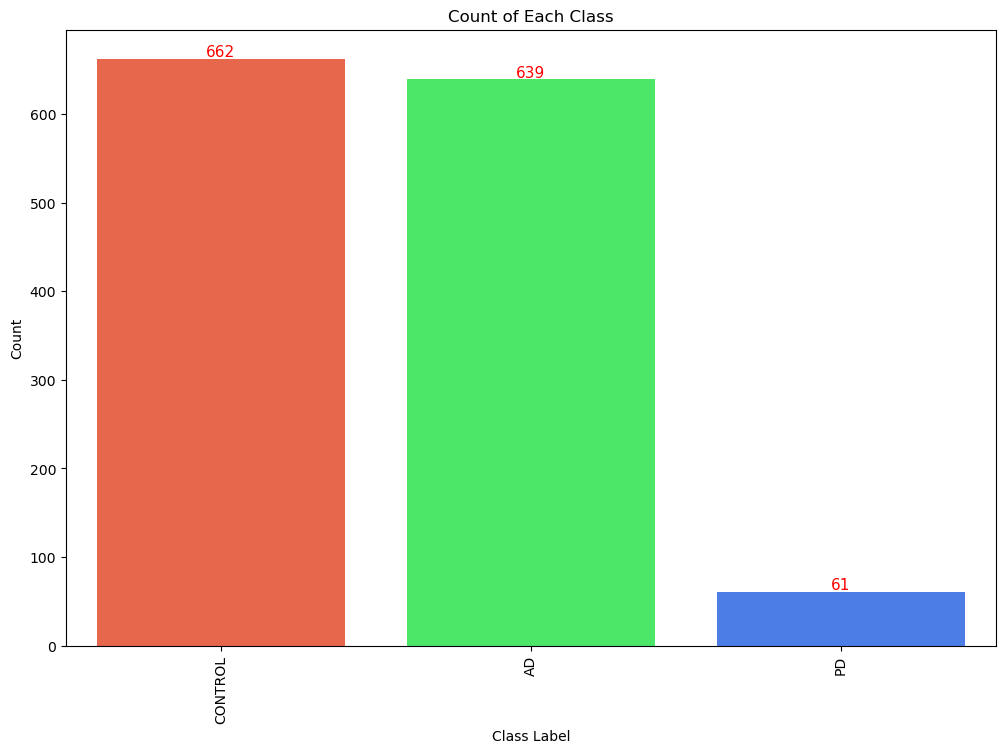

In [6]:
plt.figure(figsize=(12, 8))
sns.countplot(data=img_data_test, x='Name', palette=clr_map, order=img_data_test['Name'].value_counts().index)
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=11, color='red', xytext=(0, 5),
                       textcoords='offset points')

plt.xticks(rotation=90)
plt.title('Count of Each Class')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

#### Class Distribution Of Traning Dataset

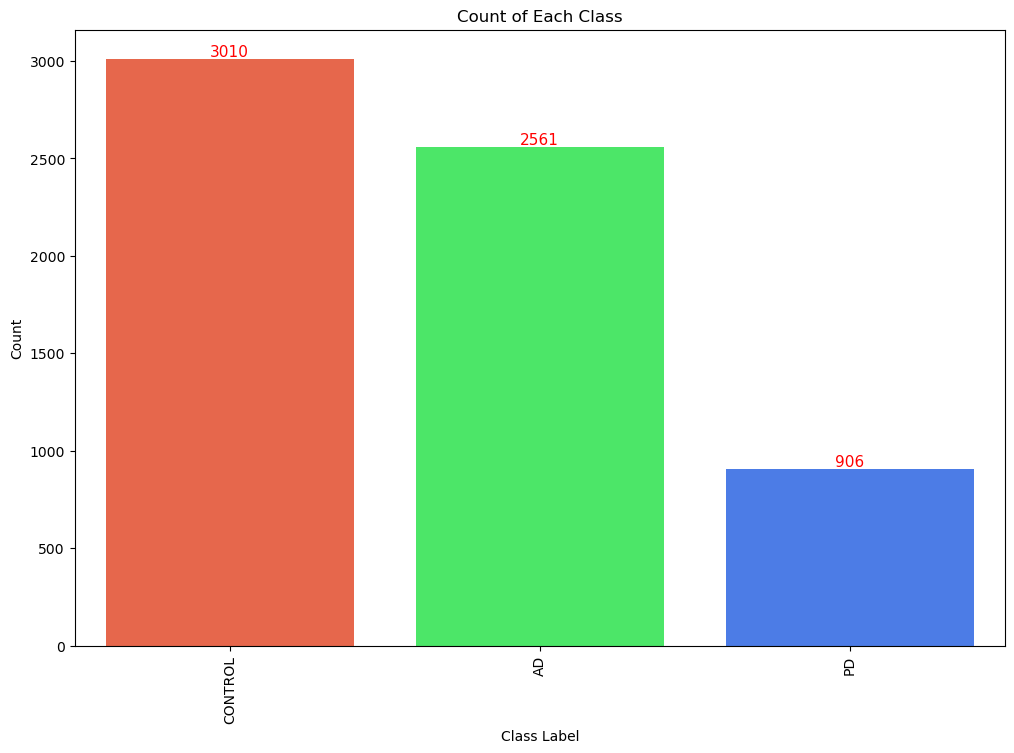

In [5]:
# Using Seaborn to plot the counts
plt.figure(figsize=(12, 8))
sns.countplot(data=img_data, x='Name', palette=clr_map, order=img_data['Name'].value_counts().index)

# Adding annotations with the count values
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=11, color='red', xytext=(0, 5),
                       textcoords='offset points')

plt.xticks(rotation=90)
plt.title('Count of Each Class')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()


### Data Augmentation

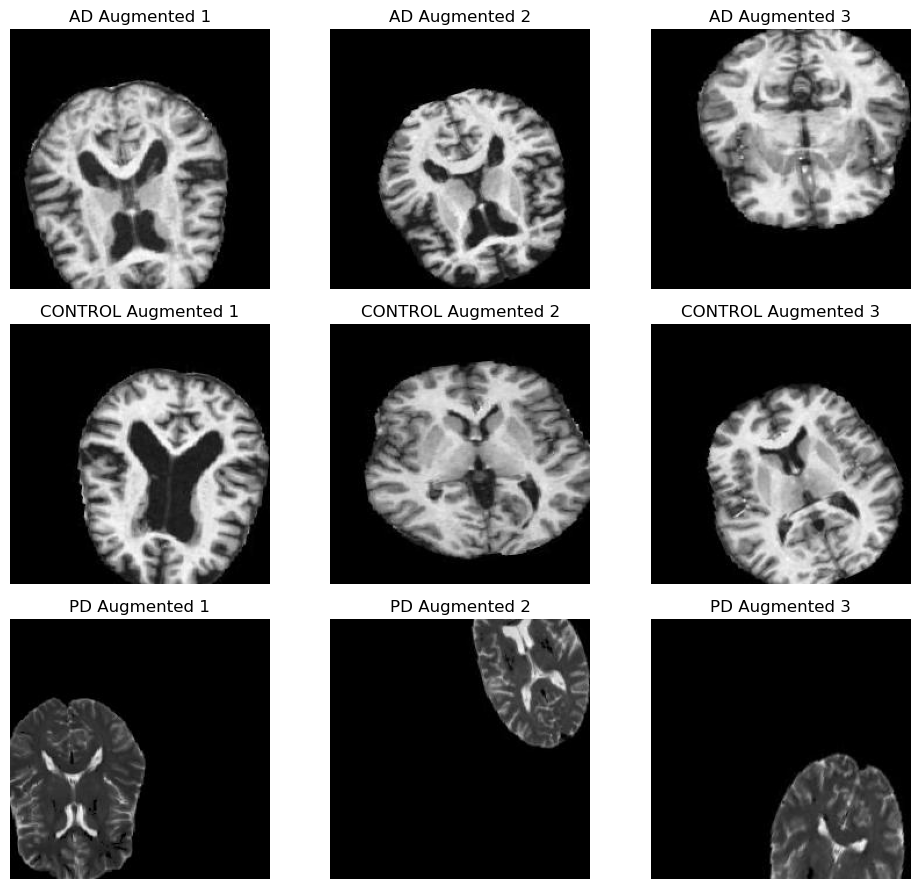

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator 
def plot_augmented_images(base_dir='augmented_data', num_samples=3):
    # Determine the number of classes
    class_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    num_classes = len(class_dirs)

    plt.figure(figsize=(10, num_classes * 3))  # Set up figure size dynamically based on classes
    img_count = 1

    for class_name in class_dirs:
        class_dir = os.path.join(base_dir, class_name)
        image_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
                       if os.path.isfile(os.path.join(class_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        np.random.shuffle(image_files)  # Randomly shuffle the list of image files

        for i in range(min(num_samples, len(image_files))):
            img_path = image_files[i]
            img = load_img(img_path, target_size=(224, 224))  # Load and resize image for consistency
            img = np.array(img)  # Convert to array for plotting

            ax = plt.subplot(num_classes, num_samples, img_count)
            ax.imshow(img / 255.)  # Normalize and display the image
            ax.set_title(f"{class_name} Augmented {i+1}")
            ax.axis('off')
            img_count += 1

    plt.tight_layout()
    plt.show()

# Call the function to plot images
plot_augmented_images('augmented_data', num_samples=3)


In [8]:
augmentations = {
    'CONTROL': ImageDataGenerator(
        rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
        shear_range=0.15, zoom_range=0.15, horizontal_flip=True, vertical_flip=True,
        fill_mode='nearest'
    ),
    'AD': ImageDataGenerator(
        rotation_range=20, width_shift_range=0.15, height_shift_range=0.15,
        shear_range=0.1, zoom_range=0.1, horizontal_flip=True,
        fill_mode='nearest'
    ),
    'PD': ImageDataGenerator(
        rotation_range=60, width_shift_range=0.4, height_shift_range=0.4,
        shear_range=0.3, zoom_range=0.3, horizontal_flip=True, vertical_flip=True,
        fill_mode='nearest'
    )
}

def apply_balanced_augmentation(data, base_dir='augmented_data', target_counts=None):
    os.makedirs(base_dir, exist_ok=True)

    for class_name, generator in augmentations.items():
        class_data = data[data['Name'] == class_name]
        save_dir = os.path.join(base_dir, class_name)
        os.makedirs(save_dir, exist_ok=True)

        current_count = class_data.shape[0]
        target_count = target_counts[class_name]
        num_to_generate = target_count - current_count

        for img_path in class_data['Link']:
            img = load_img(img_path, target_size=(224, 224))
            img = img_to_array(img)
            img = np.expand_dims(img, axis=0)
            gen_flow = generator.flow(img, batch_size=1, save_to_dir=save_dir, save_prefix='aug_', save_format='jpeg')
            
            for _ in range(min(num_to_generate, 5)):  
                next(gen_flow)

target_counts = {
    'AD': max(3500, 3010),  
    'CONTROL': max(3500, 3010),
    'PD': max(3500, 3010)
}

apply_balanced_augmentation(img_data, target_counts=target_counts)


### Class Distribution of Balanced DataSet

In [9]:
def count_images_in_directory(directory):
    counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            num_images = len([name for name in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, name))])
            counts[class_dir] = num_images
    return counts


augmented_counts = count_images_in_directory('augmented_data')
print("Augmented class distribution:", augmented_counts)

Augmented class distribution: {'AD': 10000, 'CONTROL': 10000, 'PD': 10000}


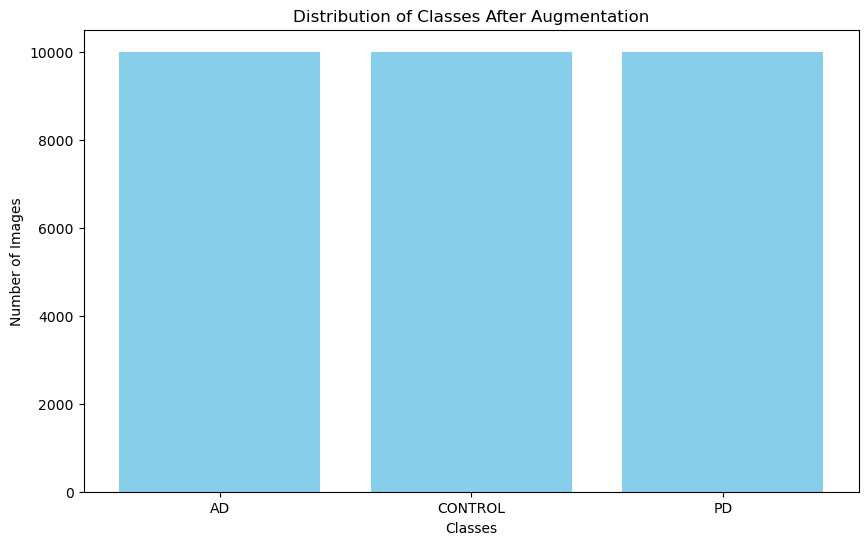

In [10]:
def plot_class_distribution(counts):
    """ Plots a bar chart of the class distribution given a dictionary of counts. """
    plt.figure(figsize=(10, 6))
    plt.bar(counts.keys(), counts.values(), color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Classes After Augmentation')
    plt.show()

plot_class_distribution(augmented_counts)

### Spilt Datase For Model Fitting Train and Validation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  
)

base_dir = 'augmented_data'


train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical', 
    subset='training',  
    shuffle=True 
)

validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  
    shuffle=True  
)



Found 24000 images belonging to 3 classes.
Found 6000 images belonging to 3 classes.


### Test Data Set For Model Evaluation

In [11]:
img_data_test['Link'] = img_data_test['Link'].astype(str)
test_dir = 'test_data'

test_generator = data_gen.flow_from_dataframe(
    img_data_test,
    x_col='Link',
    y_col='Name',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1362 validated image filenames belonging to 3 classes.


### Trained Ensemble Model VGG16 And DenseNet121

In [39]:
from keras.applications import VGG16, DenseNet121
from keras.layers import Input, Concatenate, Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import ModelCheckpoint

def build_ensemble_model_vgg_densenet(input_shape, num_classes):
    vgg16 = VGG16(include_top=False, input_shape=input_shape, weights='imagenet')
    for layer in vgg16.layers:
        layer.trainable = False
    densenet121 = DenseNet121(include_top=False, input_shape=input_shape, weights='imagenet')
    for layer in densenet121.layers:
        layer.trainable = False
    combined_output = Concatenate()([Flatten()(vgg16.output), Flatten()(densenet121.output)])
    x = BatchNormalization()(combined_output)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=[vgg16.input, densenet121.input], outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', 
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

    return model

In [40]:
model_v16_dens121 = build_ensemble_model_vgg_densenet(input_shape=(224, 224, 3), num_classes=3)

def generate_dual_input(generator):
    for batch_x, batch_y in generator:
        yield [batch_x, batch_x], batch_y  
train_dual_generator = generate_dual_input(train_generator)
validation_dual_generator = generate_dual_input(validation_generator)
test_dual_generator = generate_dual_input(test_generator)

checkpoint_path = "model_checkpoint.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', 
                                      save_best_only=True, save_weights_only=True, verbose=1)

total_train_steps = len(train_generator)
total_validation_steps = len(validation_generator)

model_D121_V16 = model_v16_dens121.fit(
    train_dual_generator,
    steps_per_epoch=len(train_generator),  
    validation_data=validation_dual_generator,
    validation_steps=total_validation_steps,
    epochs=5,
    callbacks=[checkpoint_callback]
)

Epoch 1/5
750/750 [==============================] - ETA: 0s - loss: 0.4549 - accuracy: 0.7973 - precision: 0.8042 - recall: 0.7859 - auc: 0.9376
Epoch 1: val_loss improved from inf to 0.35277, saving model to model_checkpoint.h5
750/750 [==============================] - 5252s 7s/step - loss: 0.4549 - accuracy: 0.7973 - precision: 0.8042 - recall: 0.7859 - auc: 0.9376 - val_loss: 0.3528 - val_accuracy: 0.8487 - val_precision: 0.8489 - val_recall: 0.8473 - val_auc: 0.9618
Epoch 2/5
750/750 [==============================] - ETA: 0s - loss: 0.3885 - accuracy: 0.8308 - precision: 0.8321 - recall: 0.8289 - auc: 0.9535
Epoch 2: val_loss improved from 0.35277 to 0.34284, saving model to model_checkpoint.h5
750/750 [==============================] - 5089s 7s/step - loss: 0.3885 - accuracy: 0.8308 - precision: 0.8321 - recall: 0.8289 - auc: 0.9535 - val_loss: 0.3428 - val_accuracy: 0.8502 - val_precision: 0.8504 - val_recall: 0.8498 - val_auc: 0.9634
Epoch 3/5
750/750 [=======================

### Evaluation Of Model

In [43]:
from sklearn.metrics import confusion_matrix
import numpy as np
y_true = test_generator.classes
y_pred_prob = model_v16_dens121.predict(test_dual_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


43/43 [==============================] - 232s 5s/step
Confusion Matrix:
[[459 180   0]
 [339 313  10]
 [ 58   3   0]]


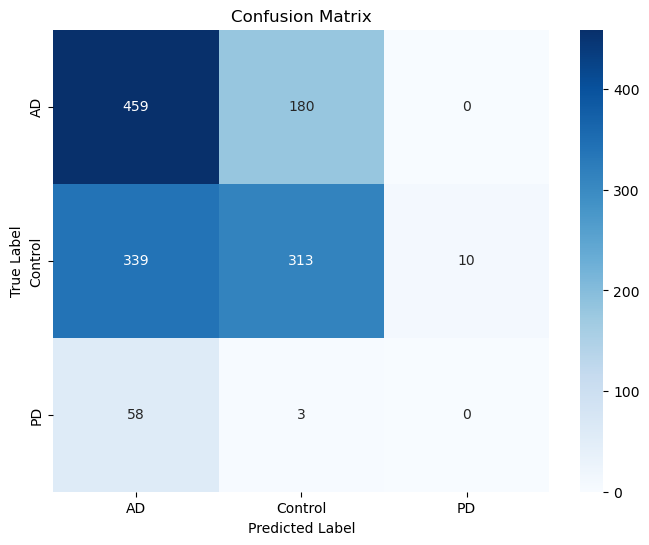

In [45]:
class_labels = ["AD", "Control", "PD"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Build Ensemble Model VGG16 And Xception

In [1]:
from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras.layers import Input, Concatenate, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

def build_ensemble_model_vgg_xception(input_shape, num_classes):
    vgg16 = VGG16(include_top=False, input_shape=input_shape, weights='imagenet')
   
    for layer in vgg16.layers:
        layer.trainable = False

    xception = Xception(include_top=False, input_shape=input_shape, weights='imagenet')
    for layer in xception.layers:
        layer.trainable = False

    for layer in vgg16.layers:
        layer._name = 'vgg_' + layer.name  

    # Rename layers in Xception to ensure uniqueness
    for layer in xception.layers:
        layer._name = 'xception_' + layer.name  


    combined_output = Concatenate()([Flatten()(vgg16.output), Flatten()(xception.output)])

    x = BatchNormalization()(combined_output)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[vgg16.input, xception.input], outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', 
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

    return model

In [21]:
model_vgg_xception = build_ensemble_model_vgg_xception(input_shape=(224, 224, 3), num_classes=3)
def generate_dual_input(generator):
    for batch_x, batch_y in generator:
        yield [batch_x, batch_x], batch_y  
train_dual_generator = generate_dual_input(train_generator)
validation_dual_generator = generate_dual_input(validation_generator)
test_dual_generator = generate_dual_input(test_generator)
checkpoint_path = "model_checkpoint.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', 
                                      save_best_only=True, save_weights_only=True, verbose=1)
total_train_steps = len(train_generator)
total_validation_steps = len(validation_generator)
history = model_vgg_xception.fit(
    train_dual_generator,
    steps_per_epoch=total_train_steps,
    validation_data=validation_dual_generator,
    validation_steps=total_validation_steps,
    epochs=5,
    callbacks=[checkpoint_callback]

)

Epoch 1/5
750/750 [==============================] - ETA: 0s - loss: 0.5374 - accuracy: 0.7717 - precision: 0.7880 - recall: 0.7399 - auc: 0.9185
Epoch 1: val_loss improved from inf to 0.41402, saving model to model_checkpoint.h5
750/750 [==============================] - 5687s 8s/step - loss: 0.5374 - accuracy: 0.7717 - precision: 0.7880 - recall: 0.7399 - auc: 0.9185 - val_loss: 0.4140 - val_accuracy: 0.8217 - val_precision: 0.8251 - val_recall: 0.8155 - val_auc: 0.9496
Epoch 2/5
750/750 [==============================] - ETA: 0s - loss: 0.4369 - accuracy: 0.8113 - precision: 0.8181 - recall: 0.8005 - auc: 0.9438
Epoch 2: val_loss improved from 0.41402 to 0.37213, saving model to model_checkpoint.h5
750/750 [==============================] - 5730s 8s/step - loss: 0.4369 - accuracy: 0.8113 - precision: 0.8181 - recall: 0.8005 - auc: 0.9438 - val_loss: 0.3721 - val_accuracy: 0.8415 - val_precision: 0.8441 - val_recall: 0.8365 - val_auc: 0.9585
Epoch 3/5
750/750 [=======================

### Evaluation Of Ensemble Model

In [28]:
from sklearn.metrics import confusion_matrix
import numpy as np

total_samples = len(test_generator.filenames)
total_steps = total_samples // test_generator.batch_size
if total_samples % test_generator.batch_size:
    total_steps += 1
y_true = test_generator.classes
y_pred_prob = model_vgg_xception.predict(test_dual_generator, steps=total_steps)
y_pred = np.argmax(y_pred_prob, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

43/43 [==============================] - 232s 5s/step
Confusion Matrix:
[[246 373  20]
 [488 174   0]
 [ 34  27   0]]


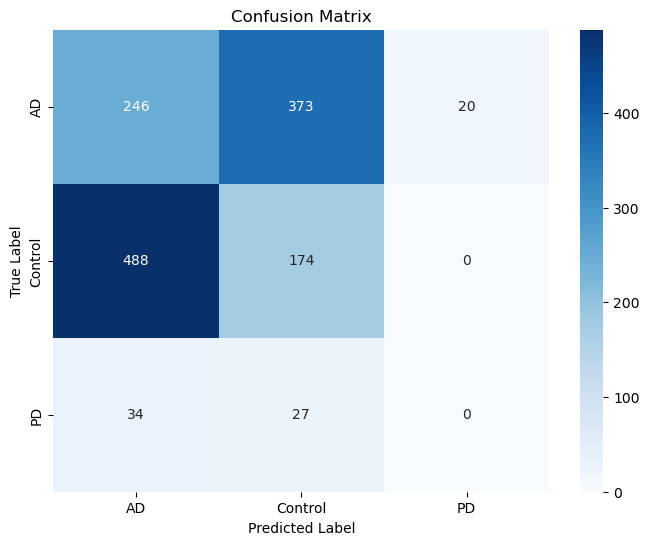

In [29]:
class_labels = ["AD", "Control", "PD"]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()